In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, make_scorer, classification_report,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
final_df=pd.read_csv("finalfile.txt", sep="\t")
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category,Collection date
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,Male,87.00,19A,B,Europe,Turkey,Severe,12-01-2024
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe,03-01-2024
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe,06-01-2024
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe,30-01-2024
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,19.00,23H,HK.3,Asia,China,Severe,01-01-2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13968,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe,03-05-2024
13969,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe,11-10-2024
13970,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe,01-03-2024
13971,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe,08-02-2024


In [4]:
final_df["Collection date"] = pd.to_datetime(final_df["Collection date"],  format="mixed", 
    dayfirst=True)
print(final_df["Collection date"].dtypes)
print(final_df["Collection date"].head())

datetime64[ns]
0   2024-01-12
1   2024-01-03
2   2024-01-06
3   2024-01-30
4   2024-01-01
Name: Collection date, dtype: datetime64[ns]


In [5]:
final_df["month"] = final_df["Collection date"].dt.to_period("M").astype(str)

In [6]:
bins   = [-np.inf, 20, 40, 60, 80, np.inf] 
labels = ["0-20", "21-40", "41-60", "61-80", "80+"]

final_df["age_band"] = pd.cut(final_df["Patient age"], bins=bins, labels=labels)

print(final_df[["Patient age", "age_band"]].head(15))

    Patient age age_band
0          87.0      80+
1          91.0      80+
2          35.0    21-40
3          70.0    61-80
4          19.0     0-20
5          60.0    41-60
6          87.0      80+
7          76.0    61-80
8          69.0    61-80
9          46.0    41-60
10         79.0    61-80
11         62.0    61-80
12         24.0    21-40
13         27.0    21-40
14         33.0    21-40


In [7]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int32


In [8]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int32


In [9]:
clade_dummies = pd.get_dummies(final_df['clade'], prefix='clade').astype(int)
final_df = pd.concat([final_df, clade_dummies], axis=1)
final_df = final_df.drop(['clade', 'clade_24C'], axis = 1)

In [10]:
Nextclade_dummies = pd.get_dummies(final_df['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df = pd.concat([final_df, Nextclade_dummies], axis=1)
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [11]:
import numpy as np
import pandas as pd

for col in ['country', 'month', 'age_band']:
    if col not in final_df.columns:
        raise KeyError(f"final_df must contain '{col}' for IPI weighting.")

final_df['__stratum__'] = (
    final_df['country'].astype(str) + '_' +
    final_df['month'].astype(str)   + '_' +
    final_df['age_band'].astype(str)
)

_counts = final_df['__stratum__'].value_counts(dropna=False)
_probs  = _counts / _counts.sum()
final_df['ipi_weight'] = final_df['__stratum__'].map(lambda s: 1.0 / _probs[s])

final_df['ipi_weight'] = final_df['ipi_weight'] / final_df['ipi_weight'].mean()

print("IPI weights computed. Summary:")
display(final_df['ipi_weight'].describe())

IPI weights computed. Summary:


count    13973.000000
mean         1.000000
std          2.756098
min          0.055730
25%          0.127972
50%          0.246803
75%          0.575874
max         20.731454
Name: ipi_weight, dtype: float64

In [12]:
X = final_df.drop(columns=['category', 'strain', 'country', 'region',
    'Collection date', 'month', 'age_band', '__stratum__', 'ipi_weight'])

In [13]:
y = final_df['category']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int32

In [14]:
weights = final_df['ipi_weight'].values
weights

array([20.73145401,  2.30349489,  0.37693553, ...,  6.91048467,
        0.10212539,  0.24680302])

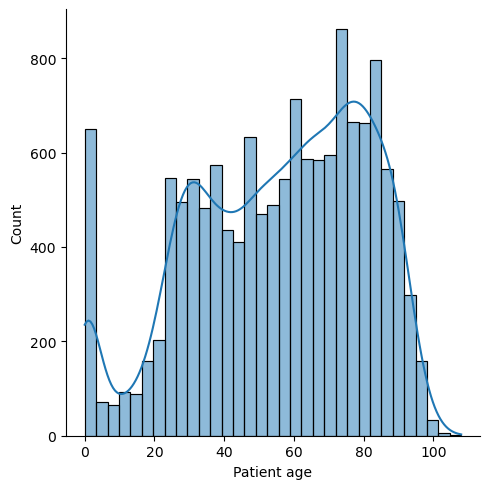

In [15]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)
sns.displot(X["Patient age"], kde=True)
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[["Patient age"]] = scaler.fit_transform(X_train[["Patient age"]]) 
X_test[["Patient age"]] = scaler.transform(X_test[["Patient age"]]) 

In [19]:
from scipy.stats import randint, uniform
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(500, 2001),         
    'max_depth': randint(10, 51),              
    'min_samples_leaf': randint(1, 4),          
    'min_samples_split': randint(1, 6)          
}

In [20]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=2)

In [21]:
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,                
    cv=5,                    
    scoring='accuracy',       
    verbose=2,
    random_state=42,
    n_jobs=2
)

In [22]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=2, random_state=42),
                   n_iter=50, n_jobs=2,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E5D2338C10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E5C606F990>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E544D60610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E571C5FE90>},
                   random_state=42, scoring='accuracy', verbose=2)

In [23]:
print("Best Parameters Found:", random_search.best_params_)

Best Parameters Found: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 564}


In [24]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [25]:
y_prob = best_model.predict_proba(X_test)[:, 1]

In [26]:
from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7992844364937388
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.82      0.75      1055
           1       0.88      0.79      0.83      1740

    accuracy                           0.80      2795
   macro avg       0.79      0.80      0.79      2795
weighted avg       0.81      0.80      0.80      2795



In [29]:
def expected_calibration_error(y_true, y_prob, n_bins=10, sample_weight=None):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    if sample_weight is None:
        sample_weight = np.ones_like(y_true, dtype=float)

    for i in range(n_bins):
        bin_mask = (y_prob >= bins[i]) & (y_prob < bins[i + 1])
        bin_size = np.sum(sample_weight[bin_mask])
        if bin_size > 0:
            bin_acc = np.average(y_true[bin_mask], weights=sample_weight[bin_mask])
            bin_conf = np.average(y_prob[bin_mask], weights=sample_weight[bin_mask])
            ece += (bin_size / np.sum(sample_weight)) * abs(bin_acc - bin_conf)
    return ece



In [30]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss
)
cv_rows = []

# Unweighted metrics
cv_rows.append({
    "Fold": 1,
    "Setting": "Unweighted",
    "AUROC": roc_auc_score(y_test, y_prob),
    "AUPRC": average_precision_score(y_test, y_prob),
    "Brier": brier_score_loss(y_test, y_prob),
    "ECE@10": expected_calibration_error(y_test, y_prob, n_bins=10),
})

# Weighted metrics
cv_rows.append({
    "Fold": 1,
    "Setting": "Weighted",
    "AUROC": roc_auc_score(y_test, y_prob, sample_weight=w_test),
    "AUPRC": average_precision_score(y_test, y_prob, sample_weight=w_test),
    "Brier": brier_score_loss(y_test, y_prob, sample_weight=w_test),
    "ECE@10": expected_calibration_error(y_test, y_prob, n_bins=10, sample_weight=w_test),
})

cv_results = pd.DataFrame(cv_rows)
summary = cv_results.groupby("Setting").agg(["mean", "std"]).round(4)

print("Per-fold results:\n", cv_results)
print("\nSummary (mean ± std across folds):\n", summary)

Per-fold results:
    Fold     Setting     AUROC     AUPRC     Brier    ECE@10
0     1  Unweighted  0.881702  0.937373  0.135340  0.030514
1     1    Weighted  0.945089  0.990443  0.073837  0.056357

Summary (mean ± std across folds):
            Fold       AUROC       AUPRC       Brier      ECE@10    
           mean std    mean std    mean std    mean std    mean std
Setting                                                            
Unweighted  1.0 NaN  0.8817 NaN  0.9374 NaN  0.1353 NaN  0.0305 NaN
Weighted    1.0 NaN  0.9451 NaN  0.9904 NaN  0.0738 NaN  0.0564 NaN


In [31]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred, sample_weight=w_test))
print(classification_report(y_test, y_pred, sample_weight=w_test))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob, sample_weight=w_test))

[[ 309.75864441   87.98283257]
 [ 196.54544291 2040.9899337 ]]
              precision    recall  f1-score   support

           0       0.61      0.78      0.69 397.741476985662
           1       0.96      0.91      0.93 2237.5353766123862

    accuracy                           0.89 2635.276853598048
   macro avg       0.79      0.85      0.81 2635.276853598048
weighted avg       0.91      0.89      0.90 2635.276853598048

Test ROC AUC: 0.9450892025615918


fpr = [0.         0.         0.         ... 0.99904537 0.99937949 1.        ]
tpr = [0.         0.14441062 0.14494861 ... 1.         1.         1.        ]
thresholds = [       inf 1.         0.99994991 ... 0.08499998 0.07781325 0.06889847]
AUC = 0.945


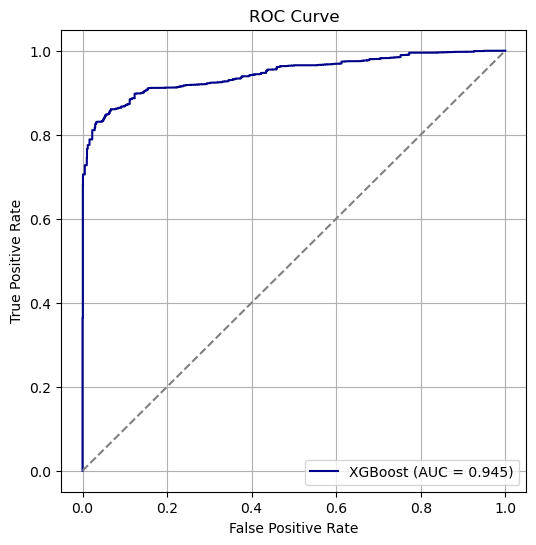

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)
auc_score = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print('fpr =', fpr)
print('tpr =', tpr)
print('thresholds =', thresholds)
print(f"AUC = {auc_score:.3f}")
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.3f})", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_xgboost.tiff', dpi=600, format='tiff')
plt.show()

In [34]:
np.set_printoptions(threshold=np.inf)  
print("False Positive Rate (FPR):\n", fpr)
print("True Positive Rate (TPR):\n", tpr)
print("Thresholds:\n", thresholds)
print(f"AUC = {auc_score:.3f}")

# Save values to a txt file
with open("roc_valueslightgbmwithoutcountryregionweighted.txt", "w") as f:
    f.write("False Positive Rate (FPR):\n")
    np.savetxt(f, fpr, fmt="%.10f")
    
    f.write("\nTrue Positive Rate (TPR):\n")
    np.savetxt(f, tpr, fmt="%.10f")
    
    f.write("\nThresholds:\n")
    np.savetxt(f, thresholds, fmt="%.10f")
    
    f.write(f"\nAUC = {auc_score:.3f}\n")

False Positive Rate (FPR):
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e